# Differences between lat-lon rectangle and boolean mask

In this notebook we will investigate the difference between two methods describing the Baltic Sea drainage area. The first and easier method uses a latitude-longitude rectangle. The second and more difficult method uses a boolean mask described by twelve corner points.

Some scientific papers, for example *Börgel et al. - 2018 - Impact of the Atlantic Multidecadal Oscillation on Baltic Sea Variability*, define the Baltic Sea catchment area as 9.6°E to 32°E and 52.4°N to 67.4°N. This area doesn't cover the whole drainage area shown in Figure 1.

<img src="baltic_drainage_area.JPG" alt="Baltic drainage area" width="50%">

<div style="font-size: 12px;">
Figure 1: Map of the drainage area of the Baltic Sea. Note the use of a spheric coordiante system in the image and how parts of the drainage area lay below 52.4°N, which serves as a lower border for Börgel et al. 
    
Source: Snoeijs-Leijonmalm and Andrén - 2017 - Why is the Baltic Sea so special to live in?
</div>

I created a boolean mask using the following twelve corner points: (18.0°E, 48.5°N), (23.0°E, 48.5°N), (28.0°E, 55.0°N), (32.0°E, 56.0°N), (35.0°E, 62.0°N), (30.0°E, 62.0°N), (29.0°E, 67.0°N), (19.0°E, 68.0°N), (12.0°E, 61.0°N), (12.0°E, 57.5°N), (8.0°E, 56.5°N), (10.0°E, 53.0°N), (13.5°E, 52.5°N). Figure 2 compares the mask and the latitude-longitude 'rectangle' in a cartesian coordinate system.

The baltic region outline is prepared:

In [42]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def subplot_cartopy_nice_baltic(ax):    
    """
    Adjust cartopy plots for the Baltic Sea
    """
    ax.set_aspect("auto")
    ax.coastlines("10m")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.0, linestyle='-')
    gl.top_labels  = False
    gl.left_labels  = True
    gl.right_labels  = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator(list(np.arange(-90, 60, 10)))
    gl.ylocator = mticker.FixedLocator(list(np.arange(-60, 80, 5)))

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    gl.xlabel_style = {'size': 23}
    gl.ylabel_style = {'size': 23}

    ax.spines['geo'].set_linewidth(5)
    ax.spines['geo'].set_edgecolor('black')
    ax.set_aspect('auto')

The graphic is plotted:

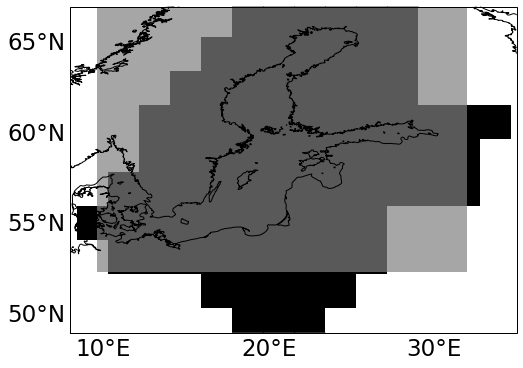

In [44]:
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import numpy as np

temp = xr.open_dataset("/students_files/data/slo0043_echam6_code167_mm_1001_8850.ncslo0043_echam6_code167_mm_1001_8850.nc")
large_scale_prec = xr.open_dataset("/students_files/data/slo0043_echam6_code142_mm_1001_8850.ncslo0043_echam6_code142_mm_1001_8850.nc")
convective_prec = xr.open_dataset("/students_files/data/slo0043_echam6_code143_mm_1001_8850.ncslo0043_echam6_code143_mm_1001_8850.nc")
sum_var = large_scale_prec['var142'] + convective_prec['var143']
prec = xr.Dataset({'var260': sum_var})
prec = prec.assign_coords(coords=large_scale_prec.coords)


corner_points = [
    (18.0, 49),
    (23.0, 49),
    (28.0, 55.0),
    (32.0, 56.0),
    (35.0, 62.0),
    (30.0, 62.0),
    (29.0, 67.0),
    (19.0, 68.0),
    (12.0, 61.0),
    (12.0, 57.5),
    (8.0, 56.5),
    (10.0, 53.0),
    (13.5, 52.5)
]

polygon = Polygon(corner_points)

lat_mask = (temp['lat'] >= polygon.bounds[1]) & (temp['lat'] <= polygon.bounds[3])
lon_mask = (temp['lon'] >= polygon.bounds[0]) & (temp['lon'] <= polygon.bounds[2])
mask = (lat_mask & lon_mask)

lat_values = temp['lat'].values
lon_values = temp['lon'].values
for i in range(len(lat_values)):
    for j in range(len(lon_values)):
        if not polygon.contains(Point(lon_values[j], lat_values[i])):
            mask[i, j] = False
            

temp['lon'] = np.reshape(temp['lon'], (-1,))
temp['lat'] = np.reshape(temp['lat'], (-1,))

x, y = np.meshgrid(temp['lon'], temp['lat'])

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
im = plt.pcolormesh(x, y, mask, cmap='gray_r', shading='auto', transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection
im = plt.axvspan(9.6, 32, ymin=0.185, ymax=1, facecolor='grey', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize='10');

subplot_cartopy_nice_baltic(ax)
ax.spines['geo'].set_linewidth(1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(8, 35)
plt.ylim(49, 67,4);
#plt.suptitle('Created grid of the Baltic Sea drainage basin.')
#plt.figtext(0, -0.1, 'The mask uses 12 corner points (see code above for coordinates). The deviation from \n common drainage basin maps is a result of different coordinate systems being used.');

plt.savefig("/students_files/marti/plots/mask_baltic")

<div style="font-size: 12px;">
Figure 2: Map of the drainage area of the Baltic Sea. The boolean mask is shown in black and the latitude-longitude 'rectangle' in grey.
</div>

Now lets look at the Baltic annual temperature averaged over the whole region from 6000 BCE - 1850 CE.

In [3]:
# mean_temp_baltic für maske und für slice, dann subtrahieren und plotten

# adjust values of lon and lat
def adjust_lon_lat(ds, lon_name, lat_name, reverse = False):
    """Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude."""
    if reverse == True:
        ds = ds.reindex({lat_name:ds[lat_name][::-1]})
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])
    ds = (ds
          .swap_dims({lon_name: '_longitude_adjusted'})
          .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
          .drop(lon_name))
    ds = ds.rename({'_longitude_adjusted': lon_name})
    return ds
temp = adjust_lon_lat(temp, lon_name="lon", lat_name="lat", reverse=True)

# mean for mask
temp_baltic_mask = temp.where(mask)
mean_temp_baltic_mask = temp_baltic_mask.mean(dim=['lat', 'lon'])

# mean for slice
temp_baltic_slice = temp.sel(lat=slice(52.4, 67.4), lon=slice(9.6, 32))
mean_temp_baltic_slice = temp_baltic_slice.mean(dim=['lat', 'lon'])

<xarray.Dataset>
Dimensions:  ()
Data variables:
    var167   float32 0.815631


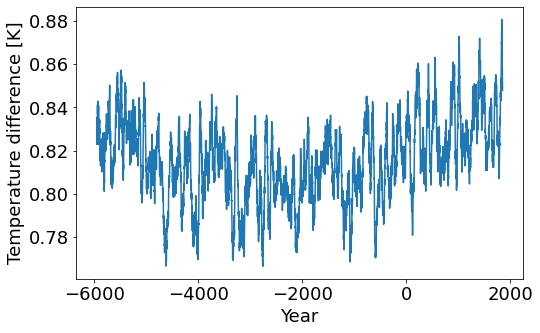

In [71]:
delta = mean_temp_baltic_mask - mean_temp_baltic_slice
mean_delta = delta.mean()
rolling_temp = delta.rolling(time=12).mean().isel(time=slice(11, None, 12))
rolling_temp = rolling_temp.rolling(time=50).mean()
rolling_temp['time'] = xr.DataArray(range(-6000, rolling_mean.time.size-6000), dims='time')


# plot the difference
plt.figure(figsize=(8, 5))
plt.plot(rolling_temp['time'], rolling_temp['var167'])
plt.xlabel('Year', fontsize =  '18')
plt.ylabel('Temperature difference [K]', fontsize =  '18')
plt.tick_params(axis='both', which='major', labelsize='18');
#plt.suptitle('Divergence between the two methods, 50y MA', fontweight='bold')
plt.savefig("/students_files/marti/plots/divergence_temp_mask");

<div style="font-size: 12px;">
Figure 3: This figure shows the difference between the 50y moving averages of the mean temperatures over the latitude-longitude 'rectangle' and over the boolean mask.
</div>

The shown difference is calculated as [temperature as of mask] - [temperature as of rectangle]. Which means, that the mask temperature is about 0.8K higher than the rectangle temperature.

In [61]:
prec = adjust_lon_lat(prec, lon_name="lon", lat_name="lat", reverse=True)

prec_baltic_mask = prec.where(mask)
mean_prec_baltic_mask = prec_baltic_mask.mean(dim=['lat', 'lon']) * 86400

# mean for slice
prec_baltic_slice = prec.sel(lat=slice(52.4, 67.4), lon=slice(9.6, 32))
mean_prec_baltic_slice = prec_baltic_slice.mean(dim=['lat', 'lon']) * 86400

<xarray.Dataset>
Dimensions:  ()
Data variables:
    var260   float64 -0.03539
<xarray.Dataset>
Dimensions:  ()
Data variables:
    var260   float64 2.315
<xarray.Dataset>
Dimensions:  ()
Data variables:
    var260   float64 -0.01529


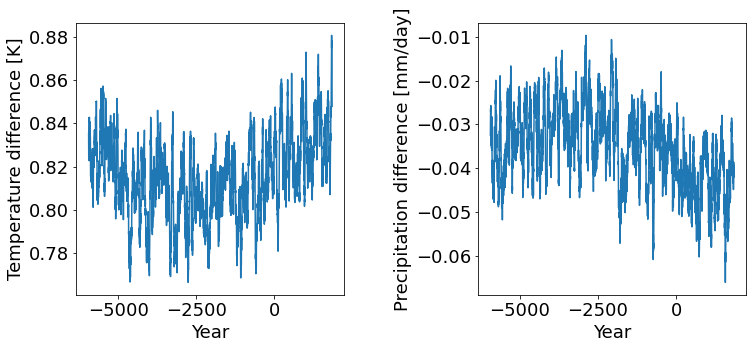

In [79]:
# differences between means
delta = mean_prec_baltic_mask - mean_prec_baltic_slice
mean_delta = delta.mean()
rolling_prec = delta.rolling(time=12).mean().isel(time=slice(11, None, 12))
rolling_prec = rolling_prec.rolling(time=50).mean()
rolling_prec['time'] = xr.DataArray(range(-6000, rolling_prec.time.size-6000), dims='time')

print(mean_delta)
print(mean_prec_baltic_mask.mean(dim=['time']))
print(mean_delta / 2.315)

# Creating the four plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.35, "wspace": 0.5})

im1 = axs[0].plot(rolling_temp['time'], rolling_temp['var167'])
axs[0].set_xlabel('Year', fontsize=18)
axs[0].set_ylabel('Temperature difference [K]', fontsize=18)
axs[0].tick_params(axis='both', labelsize=18)

im2 = axs[1].plot(rolling_prec['time'], rolling_prec['var260'])
axs[1].set_xlabel('Year', fontsize=18)
axs[1].set_ylabel('Precipitation difference [mm/day]', fontsize =  '18')
axs[1].tick_params(axis='both', which='major', labelsize=18)

#plt.suptitle('Divergence between the two methods, 50y MA', fontweight='bold')
plt.savefig("/students_files/marti/plots/divergences_mask");